# Data acquisition notebook
## CT State EV registration data

In [168]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import requests
from bs4 import BeautifulSoup

# Get data from the url 

In [169]:
url = 'https://www.atlasevhub.com/materials/state-ev-registration-data/#data'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')

In [170]:
links=[link.get('href') for link in soup.find_all('a') ]
data=[i for i in links if len(i.split('/'))>1 and i.split('/')[1]=='public']
data=[i for i in data if i.split('.')[-1]=='csv']
state_name=[i.split('/')[3].split('_')[0].upper() for i in data]

In [171]:
print(state_name)

['CA', 'CO', 'CT', 'FL', 'MT', 'MI', 'MN', 'NJ', 'NY', 'OR', 'TN', 'TX', 'VT', 'VA', 'WA', 'WI']


In [172]:
dt=pd.read_csv('https://www.atlasevhub.com/'+data[0])

In [173]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542443 entries, 0 to 2542442
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Vehicle ID                    object 
 1   County GEOID                  object 
 2   Registration Valid Date       object 
 3   DMV ID                        int64  
 4   DMV Snapshot                  object 
 5   Registration Expiration Date  float64
 6   State Abbreviation            object 
 7   Geography                     object 
 8   Vehicle Name                  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 174.6+ MB


In [174]:
dt.head()

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Tesla Roadster


# Data cleaning

1. *search for NaN*

In [175]:
dt.isna().sum()

Vehicle ID                            0
County GEOID                          0
Registration Valid Date               0
DMV ID                                0
DMV Snapshot                          0
Registration Expiration Date    2542443
State Abbreviation                    0
Geography                             0
Vehicle Name                          0
dtype: int64

Registration Expiration Date is not available, let's drop this column. 

In [176]:
dt=dt.dropna(axis=1)

In [177]:
print(dt.shape)

(2542443, 8)


In [178]:
dt.head()

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,State Abbreviation,Geography,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Tesla Roadster


# Remove columns with a unique value

In [179]:
# Remove columns with a unique value; will also remove columns with only 0 
print(f"removing {sum(dt.nunique()<2)} columns values with a unique value")
print(f"Before: dt.shape={dt.shape}")
dt=dt.loc[:,dt.nunique()>1]
print(f"After: dt.shape={dt.shape} \n")

removing 2 columns values with a unique value
Before: dt.shape=(2542443, 8)
After: dt.shape=(2542443, 6) 



In [180]:
dt.head()

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),Tesla Roadster


# We don't need Vehicle ID, DMV ID and DMV Snapshot so let's drop these columns

In [181]:
dt=dt.drop(columns=['Vehicle ID','DMV ID','DMV Snapshot'])
dt.head()

,County GEOID,Registration Valid Date,Vehicle Name
0,06099,2011-01-01,Chevrolet Volt
1,06105,2011-01-01,Nissan Leaf
2,06103,2011-01-01,Chevrolet Volt
3,06099,2011-01-01,Tesla Roadster
4,06099,2011-01-01,Tesla Roadster


# To visualize number of EV registration over the years, find the year of registration from the "Registration Valid Date"
## drop the columns "Registration Valid Date"

In [182]:
dt.insert(3,"year",pd.to_datetime(dt['Registration Valid Date']).dt.year.to_list())
dt=dt.drop(columns=['Registration Valid Date'])
dt.head()

,County GEOID,Vehicle Name,year
0,06099,Chevrolet Volt,2011
1,06105,Nissan Leaf,2011
2,06103,Chevrolet Volt,2011
3,06099,Tesla Roadster,2011
4,06099,Tesla Roadster,2011


# Number of Registrations of EV's in CA from the year 2010 to 2020

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

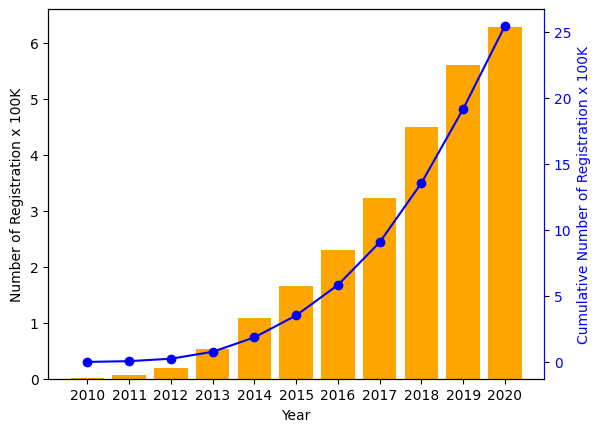

In [184]:
fig,ax=plt.subplots()
x=dt.year.value_counts().sort_index().index
y=0.00001*dt.year.value_counts().sort_index()
ax.bar(x=x,height=y,color='orange')
ax.set_xticks(x)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Registration x 100K')

ax2=ax.twinx()
ax2.plot(x,y.cumsum(),'-o',color='blue')
ax2.spines["right"].set_color("blue") 
ax2.set_ylabel('Cumulative Number of Registration x 100K',color='blue')

ax2.set_yticks(np.arange(0,26,5))
ax2.set_yticklabels(labels=np.arange(0,26,5),color="blue")

plt.show()

## Gradual increase in the number of EVs from 2010 to 2015
## Number of EVs registered increased at higher rate after 2015

# TODO:
Top 5 EVs registered over the years

County heat map